# DMS-MaPseq

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../../src')
from util import *
from config import *
import plots
import ipynbname

### # Mutations per read
- histogram
- x-axis = # mutations
- y-axis = # reads


In [2]:
for sample in study.df['sample'].unique():
    plots.mutations_per_read(study, sample)
    savefig2(ipynbname.path(), '[A] Mutations per read/'+sample)
    if not generate_plots:
        break

### Mutation identity at each position
- stacked bar graph (ACUG coloring)
- x-axis = position (number/base/both??)
- y-axis = # reads


In [3]:
%autoreload 2
for sample in study.df['sample'].unique():
    for construct in study.get_df(sample=sample)['construct'].unique():
        plots.mutation_identity_at_each_position(study, sample, construct)
        savefig2(ipynbname.path(), '[B] Mutation identity at each position/{}/{}'.format(sample, construct))
        if not generate_plots:
            break  
    if not generate_plots:
        break  

/Users/ymdt/src/highthroughputcellularbiology/notebooks/b_computational_pipeline/../../src/plots.py:69: RuntimeWarning:

invalid value encountered in divide

/Users/ymdt/src/highthroughputcellularbiology/notebooks/b_computational_pipeline/../../src/plots.py:69: RuntimeWarning:

invalid value encountered in divide

/Users/ymdt/src/highthroughputcellularbiology/notebooks/b_computational_pipeline/../../src/plots.py:69: RuntimeWarning:

invalid value encountered in divide

/Users/ymdt/src/highthroughputcellularbiology/notebooks/b_computational_pipeline/../../src/plots.py:69: RuntimeWarning:

invalid value encountered in divide

/Users/ymdt/src/highthroughputcellularbiology/notebooks/b_computational_pipeline/../../src/plots.py:69: RuntimeWarning:

invalid value encountered in divide

/Users/ymdt/src/highthroughputcellularbiology/notebooks/b_computational_pipeline/../../src/plots.py:69: RuntimeWarning:

invalid value encountered in divide

/Users/ymdt/src/highthroughputcellularbiology/notebo

### Mutation fraction at each position 
- bar graph (ACUG coloring)
- x-axis = position (number/base/both??)
- y-axis = # reads


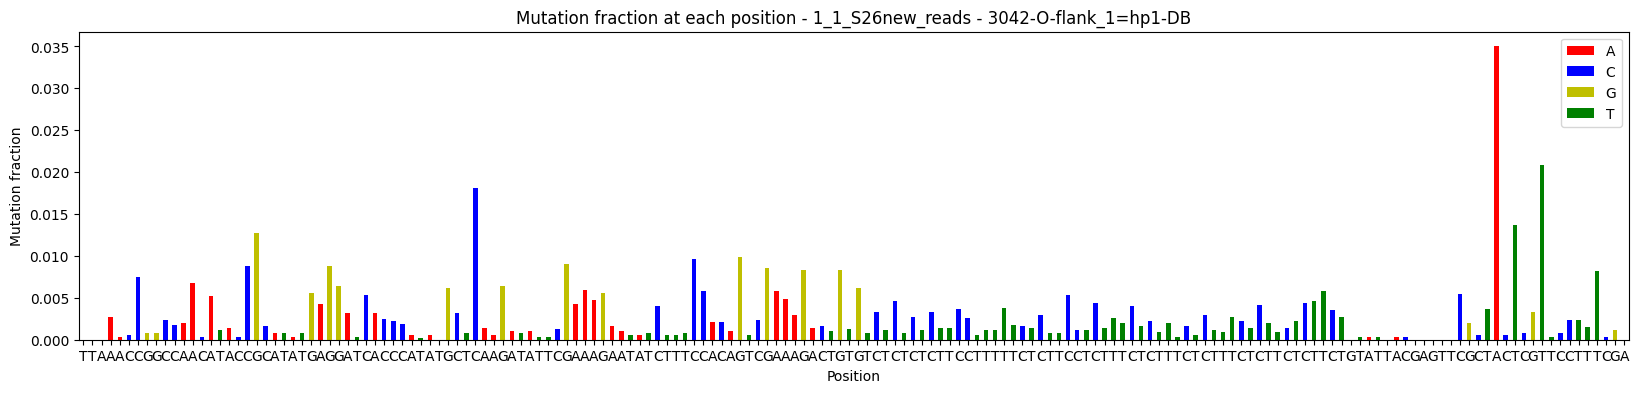

In [ ]:
for sample in study.df['sample'].unique():
    for construct in study.get_df(sample=sample)['construct'].unique():
        plots.mutation_fraction_at_each_position(study, sample, construct)
        savefig2(ipynbname.path(), '[C] Mutation fraction at each position/{}/{}'.format(sample, construct))
        if not generate_plots:
            break  
    if not generate_plots:
        break  

### Read coverage per position
- bar graph
- x-axis = position (number/base/both??)
- y-axis = coverage fraction

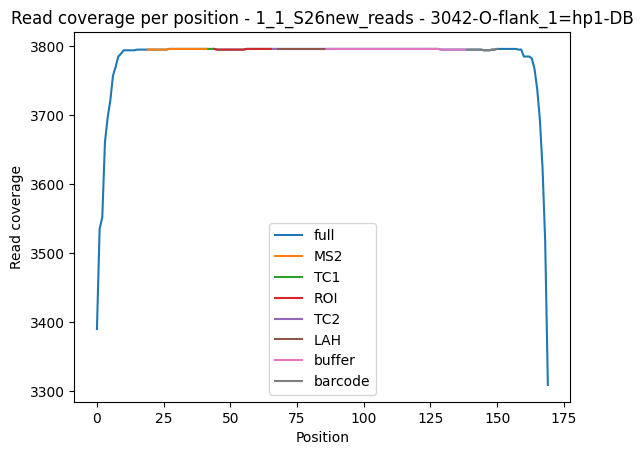

In [ ]:
for sample in study.df['sample'].unique():
    for construct in study.get_df(sample=sample)['construct'].unique():
        plots.read_coverage_per_position(study, sample, construct)
        savefig2(ipynbname.path(), '[D] Read coverage per position/{}/{}'.format(sample, construct))
        if not generate_plots:
            break  
    if not generate_plots:
        break  